# AMATH 482 Homework 3 - *Qualifying Red Wine*
## Lang Qin

# Environment Setup

We first connect our notebook to personal google drive.

In [ ]:
from google.colab import drive

# the following command loads up your google drive. It will promp you to give Colab access to your Gdrive
drive.mount('/content/drive')

Mounted at /content/drive


Then, we read in the given the dataset. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# load training and test sets 

path_to_train = '/content/drive/My Drive/AMATH 482/HW3/wine_training.csv'
path_to_test = '/content/drive/My Drive/AMATH 482/HW3/wine_test.csv'
path_to_batch = '/content/drive/My Drive/AMATH 482/HW3/wine_new_batch.csv'

df_training = np.loadtxt(path_to_train, delimiter=',')
df_test = np.loadtxt(path_to_test, delimiter=',')
df_batch = np.loadtxt(path_to_batch, delimiter=',')

Feature-label split.

In [ ]:
# training set
feature_train = df_training[:, 0:11]
label_train = df_training[:, 11]

# test set
feature_test = df_test[:, 0:11]
label_test = df_test[:, 11]

# Data Normalization

This step is to preprocess the data so that the input data are normalized
for future traning and testing.

In [ ]:
import numpy.matlib

# normalize features
feature_train_N = feature_train.shape[0]

feature_train_mean = np.mean(feature_train, axis=0)
feature_train_std = np.std(feature_train, axis=0)

feature_train_normal = (feature_train - np.matlib.repmat(feature_train_mean, feature_train_N, 1))\
    / np.matlib.repmat(feature_train_std, feature_train_N, 1)

# normalize labels
label_train_N = label_train.shape[0]

label_train_mean = np.mean(label_train, axis=0)
label_train_std = np.std(label_train, axis=0)

label_train_normal = (label_train - label_train_mean) / label_train_std

Be careful, the test set is normalized where the shift and scaling are computed
from the training set.

In [ ]:
# feature and label
feature_test_N = feature_test.shape[0]

feature_test_normal = (feature_test - np.matlib.repmat(feature_train_mean, feature_test_N, 1))\
    / np.matlib.repmat(feature_train_std, feature_test_N, 1)

label_test_normal = (label_test - label_train_mean) / label_train_std

# beatch
batch_N = df_batch.shape[0]
batch_normal = (df_batch - np.matlib.repmat(feature_train_mean, batch_N, 1))\
    / np.matlib.repmat(feature_train_std, batch_N, 1)

# Linear Regression

Use linear regression (least squares) to fit a linear model to the
training set.


In [ ]:
# train the model
A = np.concatenate(
    (np.ones((len(label_train_normal), 1)), feature_train_normal), 
    axis=1)
beta = np.linalg.lstsq(A, label_train_normal, rcond=None)[0]
mse_train_lr = 1/(len(label_train_normal))\
    * np.linalg.norm(np.dot(A,beta) - label_train_normal)**2

# test the model
At = np.concatenate(
    (np.ones((len(label_test_normal),1)), feature_test_normal),
    axis = 1)
mse_test_lr = 1/(len(label_test_normal))\
    * np.linalg.norm(np.dot(At,beta) - label_test_normal)**2

# compute batch values
A_batch = np.concatenate(
    (np.ones((batch_N,1)), batch_normal),
    axis=1)
batch_quality_lr = np.dot(A_batch,beta) * label_train_std + label_train_mean 

# report
print("Linear Regression Training MSE: ", mse_train_lr)
print("Linear Regression Test MSE: ", mse_test_lr)
print("Linear Regression new batch quality: ", batch_quality_lr)

Linear Regression Training MSE:  0.6278484956554884
Linear Regression Test MSE:  0.7471696905187203
Linear Regression new batch quality:  [6.00469789 5.28767761 5.56363072 6.067022   5.94248207]


# Gaussian (RBF) Kernal Regression

Use kernel ridge regression to fit a nonlinear model to the training set using the Gaussian (RBF) kernel

Use 10-fold CV to tune the length scale 𝜎 and the regularization parameter 𝜆 for each of the above kernels.

In [ ]:
import sklearn.model_selection as ms
import sklearn.kernel_ridge as kr

# set up paremeters for 10-fold cross-validation
Sigma = np.linspace(1, 3, 10)
Lambda = np.linspace(-4, 0, 10)

# intialize score storages
scores = np.zeros((10, 10))
std = np.zeros((10, 10))

In [ ]:
# perform 10-fold cross-validation over regression
kernal_gaussian = kr.KernelRidge(kernel='rbf')

for i in range(10):
    # initialize gamma
    kernal_gaussian.gamma = 1 / (2 * (2**Sigma[i])**2)

    for j in range(10): 
        kernal_gaussian.alpha = 2**Lambda[j]
        score = ms.cross_val_score(
            kernal_gaussian,
            feature_train_normal,
            label_train_normal,
            scoring='neg_mean_squared_error',
            cv=10)

        scores[i,j] = (np.mean(score))
        std[i,j] = (np.std(score))

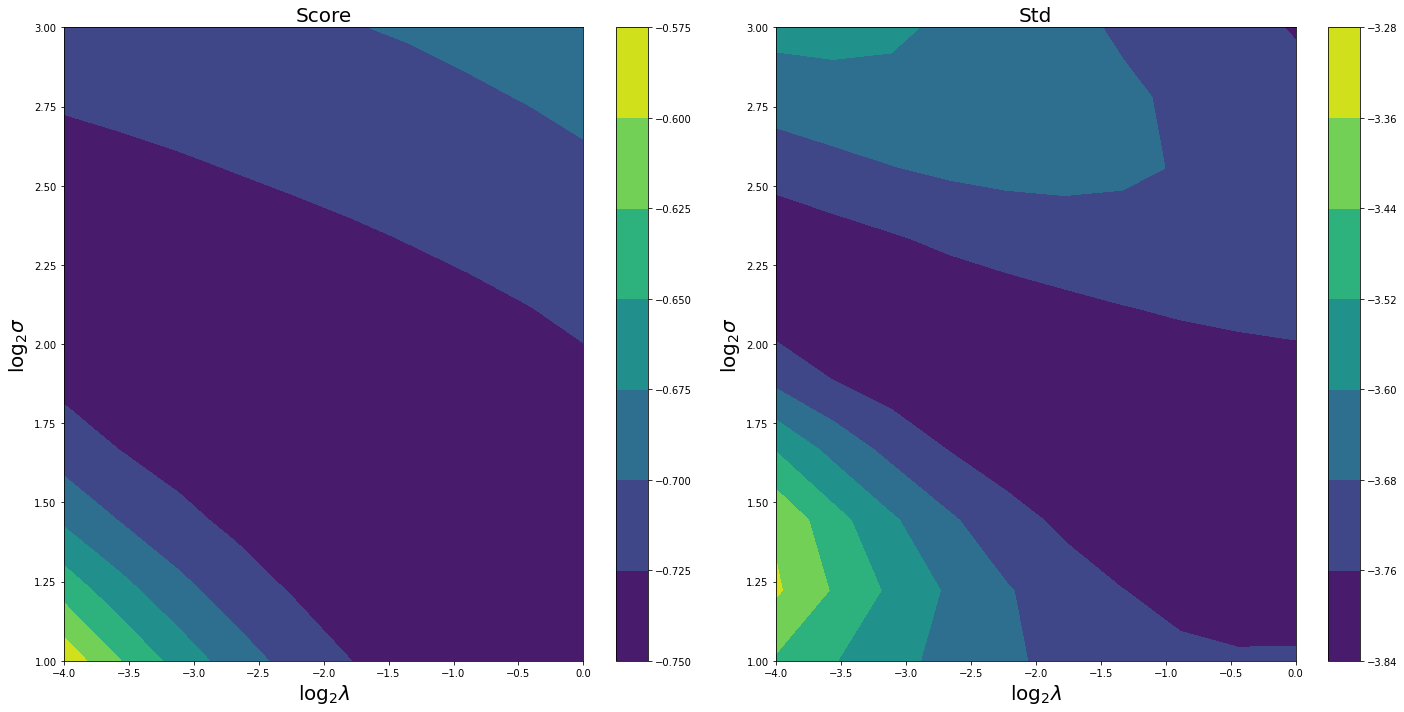

In [ ]:
# visualize score and std
xv, yv = np.meshgrid(Lambda, Sigma)

fig, ax = plt.subplots(1, 2, figsize=(20,10))

# score and lambda
ax[0].set_xlabel('$\log_2\lambda$', fontsize=20)
ax[0].set_ylabel('$\log_2\sigma$', fontsize=20)
ax[0].set_title('Score', fontsize=20)
fig.colorbar(ax[0].contourf(xv, yv, np.log2(np.abs(scores))), ax=ax[0])

# std and lambda
ax[1].set_xlabel('$\log_2\lambda$', fontsize=20)
ax[1].set_ylabel('$\log_2\sigma$', fontsize=20)
ax[1].set_title('Std', fontsize=20)
fig.colorbar(ax[1].contourf(xv, yv, np.log2(np.abs(std))), ax=ax[1])

fig.tight_layout()

In [ ]:
# outputs the highest score and corressponding lambda and sigma
index = np.array(np.where(scores==scores.max()), dtype=int).flatten()

print("Guassian Kernel Highest Score: ", scores.max())
print("Guassian Kernel Sigma: ", Sigma[index[0]])
print("Guassian Kernel Lambda: ", Lambda[index[1]])

Guassian Kernel Highest Score:  -0.5957569623170008
Guassian Kernel Sigma:  1.8888888888888888
Guassian Kernel Lambda:  -2.2222222222222223


In [ ]:
# test the best trained model
# initialize best model
trained_guassian_kernel = kr.KernelRidge(
    kernel='rbf',
    alpha=2**(Lambda[index[1]]),
    gamma=1 / (2 * (2**(Sigma[index[0]]))**2))

# fit the model with training data
trained_guassian_kernel.fit(feature_train_normal, label_train_normal)

# predict the training, test, and new batch quality
label_train_predict = trained_guassian_kernel.predict(feature_train_normal)
label_test_predict = trained_guassian_kernel.predict(feature_test_normal)
batch_quality_gk_normal = trained_guassian_kernel.predict(batch_normal)

# compute mse and denormalized batch quality
mse_train_gk = 1/(len(label_train_normal)) \
    * np.linalg.norm(label_train_predict - label_train_normal)**2
mse_test_gk = 1/(len(label_test_normal)) \
    * np.linalg.norm(label_test_predict - label_test_normal)**2
batch_quality_gk = batch_quality_gk_normal * label_train_std + label_train_mean

# report mse and new batch quality
print("Guassian Kernel Training MSE: ", mse_train_gk)
print("Guassian Kernel Test MSE: ", mse_test_gk)
print("Guassian Kernel new batch quality: ", batch_quality_gk)

Guassian Kernel Training MSE:  0.45846142299952847
Guassian Kernel Test MSE:  0.6791289111901163
Guassian Kernel new batch quality:  [5.99359168 5.43331001 5.36499355 6.1344601  6.05712892]


# Laplacian Kernel Regression

Use kernel ridge regression to fit a nonlinear model to the training set using the Laplacian kernel.

Use 10-fold CV to tune the length scale 𝜎 and the regularization parameter 𝜆 for each of the above kernels.

In [ ]:
# set up paremeters for 10-fold cross-validation
Sigma = np.linspace(1, 3, 10)
Lambda = np.linspace(-5, 0, 10)

# intialize score storages
scores = np.zeros((10, 10))
std = np.zeros((10, 10))

In [ ]:
# perform 10-fold cross-validation over regression
kernal_laplacian = kr.KernelRidge(kernel='laplacian')

for i in range(10):
    # initialize gamma
    kernal_laplacian.gamma = 1 / (2**Sigma[i])

    for j in range(10): 
        kernal_laplacian.alpha = 2**Lambda[j]
        score = ms.cross_val_score(
            kernal_laplacian,
            feature_train_normal,
            label_train_normal,
            scoring='neg_mean_squared_error',
            cv=10)

        scores[i,j] = np.mean(score)
        std[i,j] = np.std(score)

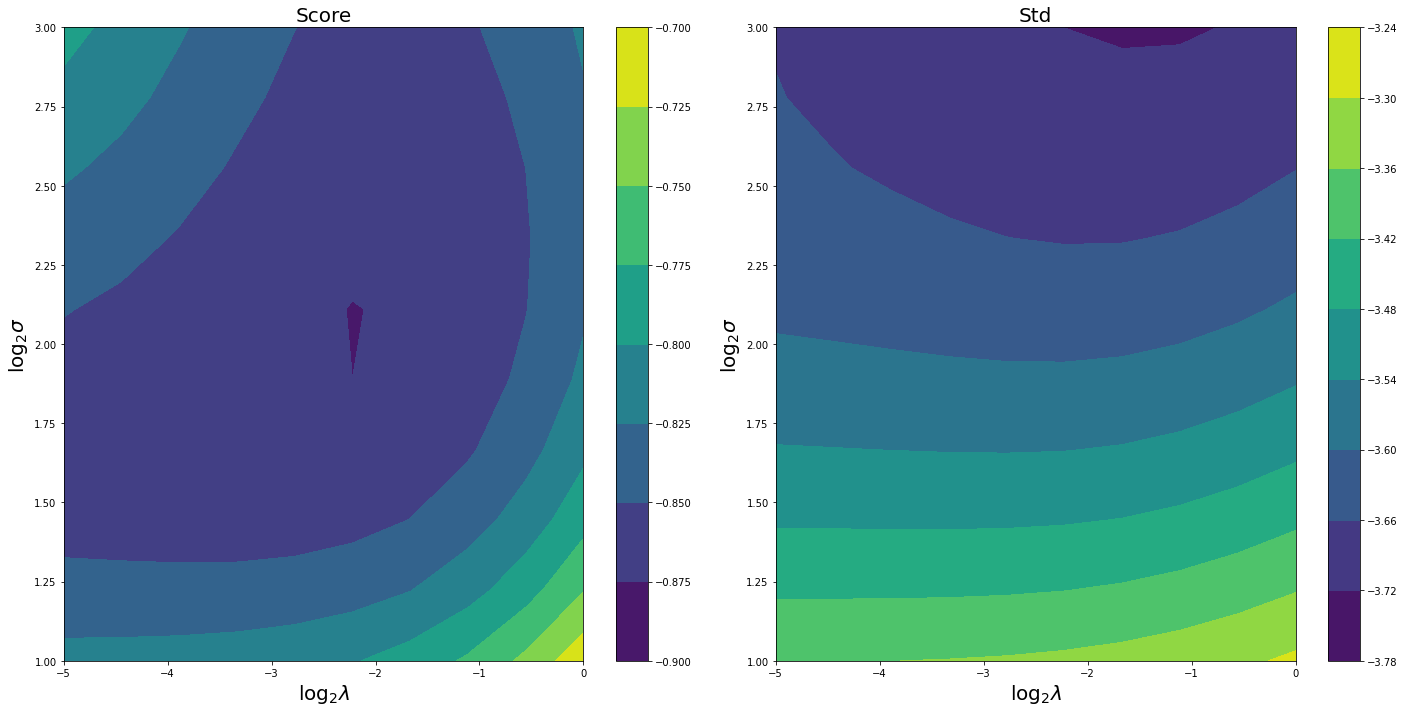

In [ ]:
# visualize score and std
xv, yv = np.meshgrid(Lambda, Sigma)

fig, ax = plt.subplots(1, 2, figsize=(20,10))

# score and lambda
ax[0].set_xlabel('$\log_2\lambda$', fontsize=20)
ax[0].set_ylabel('$\log_2\sigma$', fontsize=20)
ax[0].set_title('Score', fontsize=20)
fig.colorbar(ax[0].contourf(xv, yv, np.log2(np.abs(scores))), ax=ax[0])

# std and lambda
ax[1].set_xlabel('$\log_2\lambda$', fontsize=20)
ax[1].set_ylabel('$\log_2\sigma$', fontsize=20)
ax[1].set_title('Std', fontsize=20)
fig.colorbar(ax[1].contourf(xv, yv, np.log2(np.abs(std))), ax=ax[1])

fig.tight_layout()

In [ ]:
# outputs the highest score and corressponding lambda and sigma
index = np.array(np.where(scores==scores.max()), dtype=int).flatten()

print("Laplacian Kernel Highest Score: ", scores.max())
print("Laplacian Kernel Sigma: ", Sigma[index[0]])
print("Laplacian Kernel Lambda: ", Lambda[index[1]])

Laplacian Kernel Highest Score:  -0.5451342495185503
Laplacian Kernel Sigma:  2.111111111111111
Laplacian Kernel Lambda:  -2.2222222222222223


In [ ]:
# test the best trained model
# initialize best model
trained_laplacian_kernel = kr.KernelRidge(
    kernel='laplacian',
    alpha=2**(Lambda[index[1]]),
    gamma=1 / (2**(Sigma[index[0]])))

# fit the model with training data
trained_laplacian_kernel.fit(feature_train_normal, label_train_normal)

# predict the training, test, and new batch quality
label_train_predict = trained_laplacian_kernel.predict(feature_train_normal)
label_test_predict = trained_laplacian_kernel.predict(feature_test_normal)
batch_quality_lk_normal = trained_laplacian_kernel.predict(batch_normal)

# compute mse and denormalized batch quality
mse_train_lk = 1/(len(label_train_normal)) \
    * np.linalg.norm(label_train_predict - label_train_normal)**2
mse_test_lk = 1/(len(label_test_normal)) \
    * np.linalg.norm(label_test_predict - label_test_normal)**2
batch_quality_lk = batch_quality_lk_normal * label_train_std + label_train_mean

# report mse and new batch quality
print("Laplacian Kernel Training MSE: ", mse_train_lk)
print("Laplacian Kernel Test MSE: ", mse_test_lk)
print("Laplacian Kernel new batch quality: ", batch_quality_lk)

Laplacian Kernel Training MSE:  0.052650423557821985
Laplacian Kernel Test MSE:  0.6079848496431081
Laplacian Kernel new batch quality:  [6.05116626 5.47305444 5.6265591  5.9765956  6.01032488]
